 # HoVerNet - The CoNIC Baseline

## About this notebook
In this notebook, we provide a pretrained
[HoVerNet](https://arxiv.org/abs/1812.06499)
as the baseline model for the CoNIC training data.
The HoVerNet utilized here was trained using
only data from the CoNIC training set. You can download the pretrained
weights [here](https://drive.google.com/file/d/1oVCD4_kOS-8Wu-eS5ZqzE30F9V3Id78d/view?usp=sharing).

In the making of the baseline model, we perform following steps:
- Generating training and validation split.
- Perform the inference to get raw output.
- Perform the post-processing to convert the output into an approriate form
for the evaluation process in `compute_stats.py`.

All in all, the HoVerNet trained on the data split obtained
from this notebook achieved the validation results as follows:

**Nucleus Instance Segmentation and Classification**
---------------------------
| PQ     | mPQ<sup>+</sup>|
|--------|----------------|
| 0.6149 | 0.4998         |
---------------------------


**Cell Composition**
-----------------
| R<sup>2</sup> |
|---------------|
| 0.8585        |
-----------------

 ## Importing Libraries and Workspace Settings
 We import some Python modules that are utilised throughout the notebook.

 > **Note**: We use `tiatoolbox` extensively in this repository.
 > You can refer to [here](https://github.com/TissueImageAnalytics/tiatoolbox) for installation instructions.
 > For this notebook, we use the `develop` branch rather than `master`.

 We also declare the folders which contain the input
 data and the output.

In [1]:
import sys
import logging
import os

import cv2
import joblib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from IPython.utils import io as IPyIO
from tqdm import tqdm

mpl.rcParams['figure.dpi'] = 300

# adding the project root folder
sys.path.append('../')
from tiatoolbox.models import IOSegmentorConfig, SemanticSegmentor
from tiatoolbox.utils.visualization import overlay_prediction_contours

from misc.utils import cropping_center, recur_find_ext, rm_n_mkdir, rmdir

# Random seed for deterministic
SEED = 5
# The number of nuclei within the dataset/predictions.
# For CoNIC, we have 6 (+1 for background) types in total.
NUM_TYPES = 7
# The path to the directory containg images.npy etc.
DATA_DIR = '../data/'
# The path to the pretrained weights
PRETRAINED = '../results/isbi_model_05/net_epoch=30.tar'
# PRETRAINED = '../results/baseline_model/hovernet-conic.pth'
#PRETRAINED = '../../hover_net/exp_output/local/models/hovernet-pretrained.pth'
# The path to contain output and intermediate processing results
OUT_DIR = '../results/isbi_model_05/output/'

 # Generating Data Splits
 Here, we show how the training data is split into the training
 and validation subsets. The CoNIC training data comes from multiple
 sources. To ensure that we have a balanced dataset, we use stratified sampling according to the data source.

 For the baseline model, we utilize 80% the number of patches
 for training and the remaining for validation. However, because
 we apply stratified sampling according to the origin, the final number of patches may not be 80/20 (each image may contain a different number of patches). Therefore, we generate a number of splits (indicated
 via the `NUM_TRIALS` variable) and select the one that has the
 number of patches that most closely matches with our expected ratio.

 Lastly, to ensure the reproducibility of the sampling, we also provide a random seed.

In [2]:
NUM_TRIALS = 10  # number of splits to be generated
TRAIN_SIZE = 0.8
VALID_SIZE = 0.2

In [3]:
#from sklearn.model_selection import StratifiedShuffleSplit

#info = pd.read_csv(f'{DATA_DIR}/patch_info.csv')
#file_names = np.squeeze(info.to_numpy()).tolist()

#img_sources = [v.split('-')[0] for v in file_names]
#img_sources = np.unique(img_sources)

#cohort_sources = [v.split('_')[0] for v in img_sources]
#_, cohort_sources = np.unique(cohort_sources, return_inverse=True)

#splitter = StratifiedShuffleSplit(
#    n_splits=NUM_TRIALS,
#    train_size=TRAIN_SIZE,
#    test_size=VALID_SIZE,
#    random_state=SEED
#)

splits = [{
    #'train': pd.read_csv('../../hover_net/exp_output/local/data/ids_train_80.csv')['ids'].values,
    'valid': pd.read_csv('../../hover_net/exp_output/local/data/ids_eval_80.csv')['ids'].values
}]
joblib.dump(splits, f"{OUT_DIR}/splits.dat")

['../results/isbi_model_05/output//splits.dat']

 # Inference
 To further simplify the inference process, we utilise `tiatoolbox`
 which already contains the inference mechanism. This functionality
 accepts a list of image paths as input. Therefore, we will turn `images.npy` into individual `*.png` for the inference process.

 > **Note**: We use the first fold (trial) from the splits generated above
 > for training. Therefore, we need to extract the corresponding ground truth
 > for the validation evaluation process.

In [4]:
# The fold to use
FOLD_IDX = 0

In [5]:
imgs = np.load(f'{DATA_DIR}/images.npy')
labels = np.load(f'{DATA_DIR}/labels.npy')

splits = joblib.load(f'{OUT_DIR}/splits.dat')
valid_indices = splits[FOLD_IDX]['valid']

rm_n_mkdir(f'{OUT_DIR}/imgs/')
for idx in valid_indices:
    img = imgs[idx]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(f'{OUT_DIR}/imgs/{idx:04d}.png', img)

valid_labels = labels[valid_indices]
np.save(f'{OUT_DIR}/valid_true.npy', valid_labels)

In [6]:
from net_desc import HoVerNetConic
from termcolor import colored

def convert_pytorch_checkpoint(net_state_dict):
    variable_name_list = list(net_state_dict.keys())
    is_in_parallel_mode = all(v.split(".")[0] == "module" for v in variable_name_list)
    if is_in_parallel_mode:
        colored_word = colored("WARNING", color="red", attrs=["bold"])
        print(
            (
                "%s: Detect checkpoint saved in data-parallel mode."
                " Converting saved model to single GPU mode." % colored_word
            ).rjust(80)
        )
        net_state_dict = {
            ".".join(k.split(".")[1:]): v for k, v in net_state_dict.items()
        }
    return net_state_dict

checkpoint = torch.load(PRETRAINED)
if 'desc' in checkpoint:
    checkpoint = checkpoint['desc']
    checkpoint = convert_pytorch_checkpoint(checkpoint)
torch.save(checkpoint, "model.pth")

pretrained = torch.load("model.pth")
model = HoVerNetConic(num_types=NUM_TYPES)
model.load_state_dict(pretrained)

# Tile prediction
predictor = SemanticSegmentor(
    model=model,
    num_loader_workers=2,
    batch_size=6,
)

In [7]:
# Define the input/output configurations
ioconfig = IOSegmentorConfig(
    input_resolutions=[
        {'units': 'baseline', 'resolution': 1.0},
    ],
    output_resolutions=[
        {'units': 'baseline', 'resolution': 1.0},
        {'units': 'baseline', 'resolution': 1.0},
        {'units': 'baseline', 'resolution': 1.0},
    ],
    save_resolution={'units': 'baseline', 'resolution': 1.0},
    patch_input_shape=[256, 256],
    patch_output_shape=[256, 256],
    stride_shape=[256, 256],
)

logger = logging.getLogger()
logger.disabled = True

infer_img_paths = recur_find_ext(f'{OUT_DIR}/imgs/', ['.png'])
rmdir(f'{OUT_DIR}/raw/')

# capture all the printing to avoid cluttering the console
with IPyIO.capture_output() as captured:
    output_file = predictor.predict(
        infer_img_paths,
        masks=None,
        mode='tile',
        on_gpu=True,
        ioconfig=ioconfig,
        crash_on_exception=True,
        save_dir=f'{OUT_DIR}/raw/'
    )

|2022-03-13|19:39:06.643| [WARNING] /srv/scherr/anaconda3_20200826/envs/hovernet_jupyter2/lib/python3.9/site-packages/tiatoolbox/models/engine/semantic_segmentor.py:1026: UserWarning: WSIPatchDataset only reads image tile at `units="baseline"`. Resolutions will be converted to baseline value.
  warnings.warn(

|2022-03-13|19:39:06.707| [WARNING] /srv/scherr/anaconda3_20200826/envs/hovernet_jupyter2/lib/python3.9/site-packages/tiatoolbox/models/engine/semantic_segmentor.py:274: UserWarning: WSIPatchDataset only reads image tile at `units="baseline"`. Resolutions will be converted to baseline value.
  warnings.warn(

|2022-03-13|19:39:06.710| [WARNING] /srv/scherr/anaconda3_20200826/envs/hovernet_jupyter2/lib/python3.9/site-packages/tiatoolbox/wsicore/wsimeta.py:171: UserWarning: Raw data is None
  warnings.warn("Raw data is None")

|2022-03-13|19:39:06.710| [WARNING] /srv/scherr/anaconda3_20200826/envs/hovernet_jupyter2/lib/python3.9/site-packages/tiatoolbox/wsicore/wsimeta.py:174: User

 Once we have the HoVerNet raw inference output, we apply post processing
 to obtain the final results. For CoNIC, there are two tasks that
 are linked with each other:
 - The instance segmentation and classification of nuclei.
 - The cellular compositions within the provided patches.
 Rather than directly predicting the 2nd set of results from images, we simply use the final output of HoVerNet. Thus, to make the code more organised, we separate these tasks into their own funtion.

In [8]:
def process_segmentation(np_map, hv_map, tp_map):
    # HoVerNet post-proc is coded at 0.25mpp so we resize
    np_map = cv2.resize(np_map, (0, 0), fx=2.0, fy=2.0)
    hv_map = cv2.resize(hv_map, (0, 0), fx=2.0, fy=2.0)
    tp_map = cv2.resize(
                    tp_map, (0, 0), fx=2.0, fy=2.0,
                    interpolation=cv2.INTER_NEAREST)

    inst_map = model._proc_np_hv(np_map[..., None], hv_map)
    inst_dict = model._get_instance_info(inst_map, tp_map)

    # Generating results match with the evaluation protocol
    type_map = np.zeros_like(inst_map)
    inst_type_colours = np.array([
        [v['type']] * 3 for v in inst_dict.values()
    ])
    type_map = overlay_prediction_contours(
        type_map, inst_dict,
        line_thickness=-1,
        inst_colours=inst_type_colours)

    pred_map = np.dstack([inst_map, type_map])
    # The result for evaluation is at 0.5mpp so we scale back
    pred_map = cv2.resize(
                    pred_map, (0, 0), fx=0.5, fy=0.5,
                    interpolation=cv2.INTER_NEAREST)
    return pred_map

In [9]:
def process_composition(pred_map):
    # Only consider the central 224x224 region,
    # as noted in the challenge description paper
    pred_map = cropping_center(pred_map, [224, 224])
    inst_map = pred_map[..., 0]
    type_map = pred_map[..., 1]
    # ignore 0-th index as it is 0 i.e background
    uid_list = np.unique(inst_map)[1:]

    if len(uid_list) < 1:
        type_freqs = np.zeros(NUM_TYPES)
        return type_freqs
    uid_types = [
        np.unique(type_map[inst_map == uid])
        for uid in uid_list
    ]
    type_freqs_ = np.unique(uid_types, return_counts=True)
    # ! not all types exist within the same spatial location
    # ! so we have to create a placeholder and put them there
    type_freqs = np.zeros(NUM_TYPES)
    type_freqs[type_freqs_[0]] = type_freqs_[1]
    return type_freqs

 Now we actually perform the post-processing using the input
 output file mapping obtained previously from the inference process.

In [10]:
output_file = f'{OUT_DIR}/raw/file_map.dat'
output_info = joblib.load(output_file)

semantic_predictions = []
composition_predictions = []
for input_file, output_root in tqdm(output_info):
    img = cv2.imread(input_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    np_map = np.load(f'{output_root}.raw.0.npy')
    hv_map = np.load(f'{output_root}.raw.1.npy')
    tp_map = np.load(f'{output_root}.raw.2.npy')

    pred_map = process_segmentation(np_map, hv_map, tp_map)
    type_freqs = process_composition(pred_map)
    semantic_predictions.append(pred_map)
    composition_predictions.append(type_freqs)
semantic_predictions = np.array(semantic_predictions)
composition_predictions = np.array(composition_predictions)

  1%|▎                                          | 7/968 [00:00<00:46, 20.46it/s]|2022-03-13|19:40:26.813| [WARNING] /srv/scherr/anaconda3_20200826/envs/hovernet_jupyter2/lib/python3.9/site-packages/tiatoolbox/models/architecture/hovernet.py:555: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  marker = remove_small_objects(marker, min_size=obj_size)

100%|█████████████████████████████████████████| 968/968 [00:55<00:00, 17.56it/s]


In [11]:
# Saving the results for segmentation
np.save(f'{OUT_DIR}/valid_pred.npy', semantic_predictions)

# Saving the results for composition prediction
TYPE_NAMES = [
    "neutrophil", "epithelial", "lymphocyte",
    "plasma", "eosinophil", "connective"
]
df = pd.DataFrame(
    composition_predictions[:, 1:].astype(np.int32),
)
df.columns = TYPE_NAMES
df.to_csv(f'{OUT_DIR}/valid_pred_cell.csv', index=False)

# Load up the composition ground truth and
# save the validation portion
df = pd.read_csv(f'{DATA_DIR}/counts.csv')
true_compositions = df.to_numpy()[valid_indices]
df = pd.DataFrame(
    true_compositions.astype(np.int32),
)
df.columns = TYPE_NAMES
df.to_csv(f'{OUT_DIR}/valid_true_cell.csv', index=False)

 # Visualization
 To wrap everything up, we randomly select some samples within the validation
 set and plot their associated ground truth and predictions

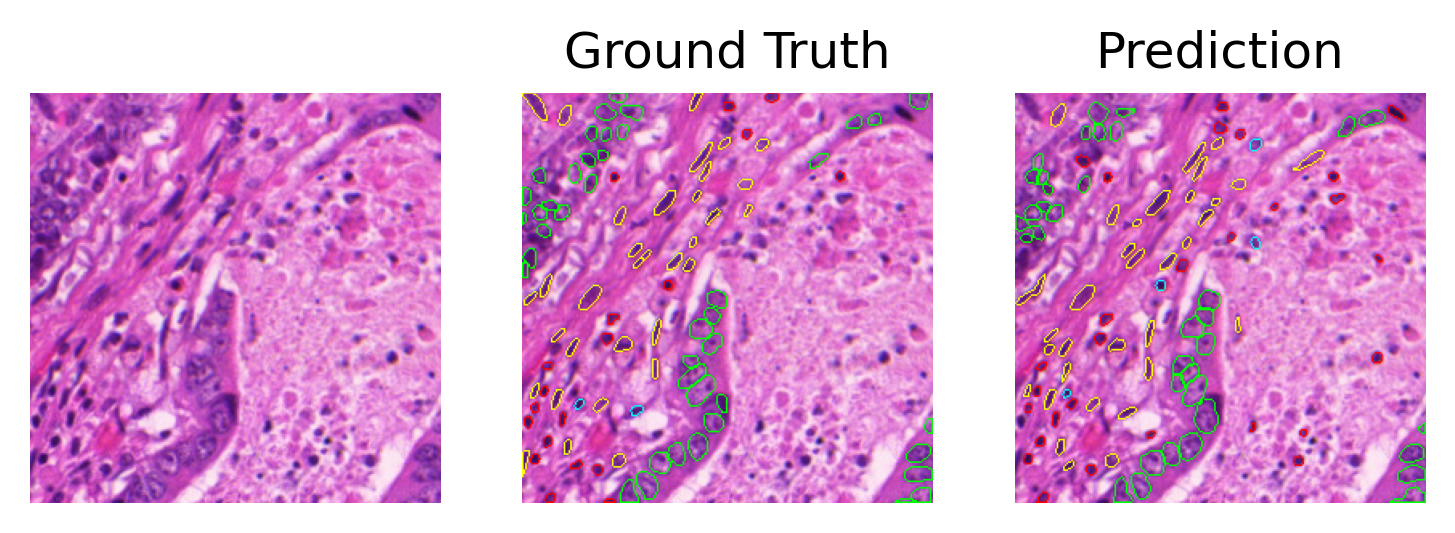

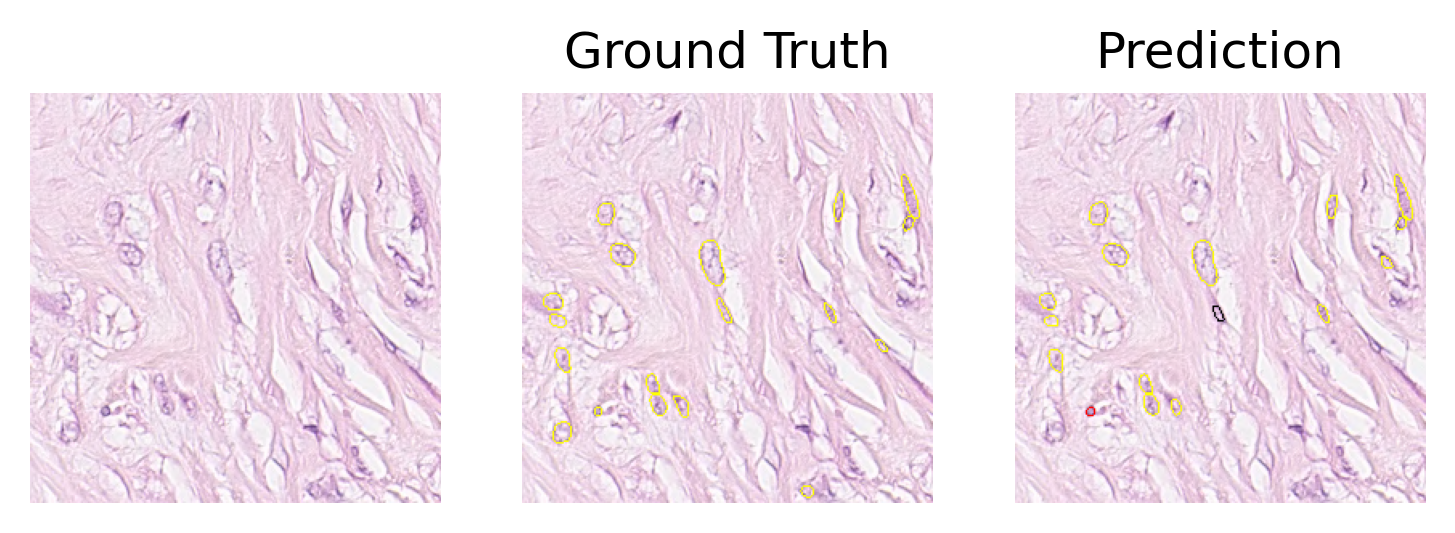

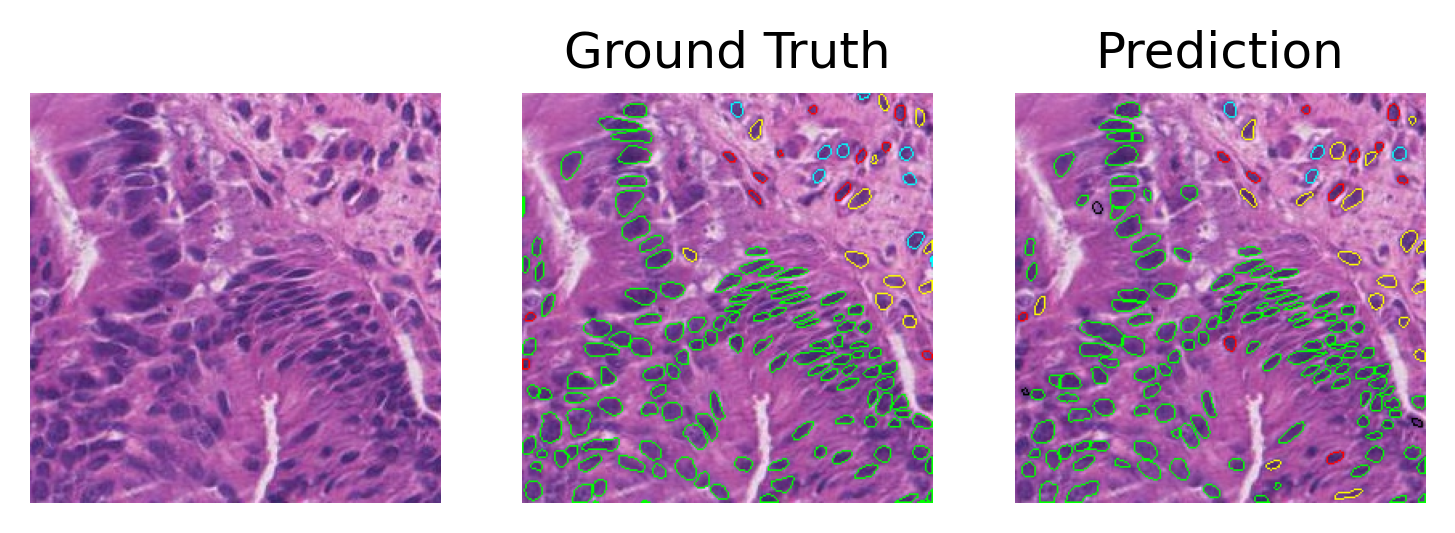

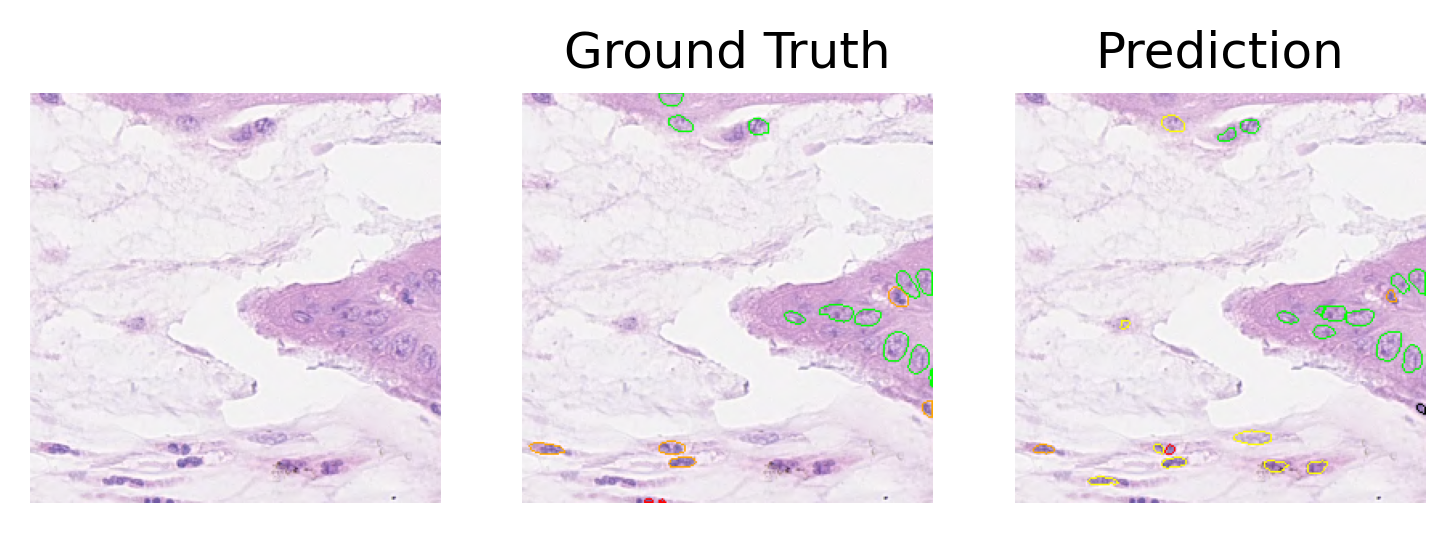

In [12]:
semantic_true = np.load(f'{OUT_DIR}/valid_true.npy')
semantic_pred = np.load(f'{OUT_DIR}/valid_pred.npy')

output_file = f'{OUT_DIR}/raw/file_map.dat'
output_info = joblib.load(output_file)

np.random.seed(SEED)
selected_indices = np.random.choice(len(valid_indices), 4)

PERCEPTIVE_COLORS = [
    (  0,   0,   0),
    (255, 165,   0),
    (  0, 255,   0),
    (255,   0,   0),
    (  0, 255, 255),
    (  0,   0, 255),
    (255, 255,   0),
]

for idx in selected_indices:
    img = cv2.imread(output_info[idx][0])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    inst_map = semantic_pred[idx][..., 0]
    type_map = semantic_pred[idx][..., 1]
    pred_inst_dict = model._get_instance_info(inst_map, type_map)

    inst_map = semantic_true[idx][..., 0]
    type_map = semantic_true[idx][..., 1]
    true_inst_dict = model._get_instance_info(inst_map, type_map)

    inst_type_colours = np.array([
        PERCEPTIVE_COLORS[v['type']]
        for v in true_inst_dict.values()
    ])
    overlaid_true = overlay_prediction_contours(
        img, true_inst_dict,
        inst_colours=inst_type_colours,
        line_thickness=1
    )

    inst_type_colours = np.array([
        PERCEPTIVE_COLORS[v['type']]
        for v in pred_inst_dict.values()
    ])
    overlaid_pred = overlay_prediction_contours(
        img, pred_inst_dict,
        inst_colours=inst_type_colours,
        line_thickness=1
    )

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(overlaid_true)
    plt.title('Ground Truth')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(overlaid_pred)
    plt.title('Prediction')
    plt.axis('off')
    plt.show()